In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import echopype as ep

In [4]:
data_path = "/Users/wu-jung/code_git/echopype/echopype/test_data/EK60/ncei-wcsd/Summer2017-D20170719-T211347.raw"

In [8]:
ed = ep.open_raw(data_path, sonar_model="EK60")

12:03:52  parsing file Summer2017-D20170719-T211347.raw, time of first ping: 2017-Jul-19 21:13:47


In [10]:
Sv = ep.calibrate.compute_Sv(ed)

In [11]:
Sv

<xarray.Dataset>
Dimensions:                (channel: 3, ping_time: 534, range_sample: 3957,
                            filenames: 1, time3: 534)
Coordinates:
  * channel                (channel) <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-...
  * ping_time              (ping_time) datetime64[ns] 2017-07-19T21:13:47.984...
  * range_sample           (range_sample) int64 0 1 2 3 ... 3953 3954 3955 3956
  * time3                  (time3) datetime64[ns] 2017-07-19T21:13:47.9849999...
Dimensions without coordinates: filenames
Data variables:
    Sv                     (channel, ping_time, range_sample) float64 0.5591 ...
    echo_range             (channel, ping_time, range_sample) float64 0.0 ......
    frequency_nominal      (channel) float64 1.8e+04 3.8e+04 1.2e+05
    sound_speed            (channel, ping_time) float64 1.481e+03 ... 1.481e+03
    sound_absorption       (channel, ping_time) float64 0.002822 ... 0.03259
    sa_correction          (ping_time, channel) float64 -0.7 -0.52 ... -0.3
    gain_correction        (ping_time, channel) float64 22.95 26.07 ... 26.55
    equivalent_beam_angle  (channel, ping_time) float64 -17.37 -17.37 ... -20.47
    source_filenames       (filenames) <U99 '/Users/wu-jung/code_git/echopype...
    water_level            (channel, time3) float64 dask.array<chunksize=(3, 534), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.6.0
    processing_time:              2022-07-04T19:04:03Z
    processing_function:          calibrate.compute_Sv

In [12]:
def _check_range_uniqueness(da):
    """
    Check if range (``echo_range``) changes across ping in a given frequency channel.
    """
    # squeeze to remove "channel" dim if present
    # TODO: not sure why not already removed for the AZFP case. Investigate.
    da = da.squeeze()

    # remove pings with NaN entries if exist
    # since goal here is to check uniqueness
    if np.unique(da.isnull(), axis=0).shape[0] != 1:
        da = da.dropna(dim="ping_time", how="any")

    # remove padded NaN entries if exist for all pings
    da = da.dropna(dim="range_sample", how="all")

    ping_time_idx = np.argwhere([dim == "ping_time" for dim in da.dims])[0][0]
    if np.unique(da, axis=ping_time_idx).shape[ping_time_idx] == 1:
        return xr.DataArray(data=True, coords={"channel": da["channel"].values})
    else:
        return xr.DataArray(data=False, coords={"channel": da["channel"].values})

In [13]:
ds_Sv = Sv.copy()

In [14]:
range_meter_bin = 20
ping_time_bin = "20S"

In [15]:
if not ds_Sv["echo_range"].groupby("channel").apply(_check_range_uniqueness).all():
    raise ValueError(
        "echo_range variable changes across pings in at least one of the frequency channels."
    )

In [16]:
range_interval = np.arange(0, ds_Sv["echo_range"].max() + range_meter_bin, range_meter_bin)

In [17]:
range_interval

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
       220., 240., 260., 280., 300., 320., 340., 360., 380., 400., 420.,
       440., 460., 480., 500., 520., 540., 560., 580., 600., 620., 640.,
       660., 680., 700., 720., 740., 760.])

In [18]:
ds = ds_Sv.isel(channel=0)

In [22]:
ds["echo_range"]

<xarray.DataArray 'echo_range' (ping_time: 534, range_sample: 3957)>
array([[  0.        ,   0.        ,   0.        , ..., 748.98353211,
        749.17305223, 749.36257236],
       [  0.        ,   0.        ,   0.        , ..., 748.98353211,
        749.17305223, 749.36257236],
       [  0.        ,   0.        ,   0.        , ..., 748.98353211,
        749.17305223, 749.36257236],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 748.98353211,
        749.17305223, 749.36257236],
       [  0.        ,   0.        ,   0.        , ..., 748.98353211,
        749.17305223, 749.36257236],
       [  0.        ,   0.        ,   0.        , ..., 748.98353211,
        749.17305223, 749.36257236]])
Coordinates:
    channel       <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11'
  * ping_time     (ping_time) datetime64[ns] 2017-07-19T21:13:47.984999936 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 3952 3953 3954 3955 3956
Attributes:
    long_name:  Range distance
    units:      m

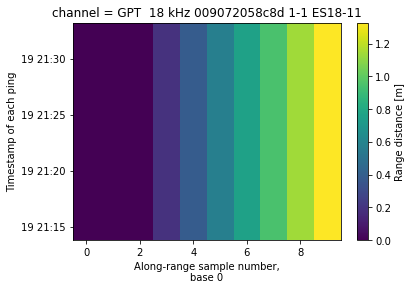

In [27]:
ds["echo_range"].isel(range_sample=slice(None,10)).plot()

In [25]:
sv = 10 ** (ds["Sv"] / 10).squeeze()  # average should be done in linear domain

In [29]:
er = ds["echo_range"].dropna(dim="range_sample", how="all").dropna(dim="ping_time").isel(ping_time=0)

In [31]:
sv = sv.sel(range_sample=er.range_sample.values)

In [32]:
sv.coords["echo_range"] = (["range_sample"], er.range_sample.values)

In [33]:
sv = sv.swap_dims({"range_sample": "echo_range"})

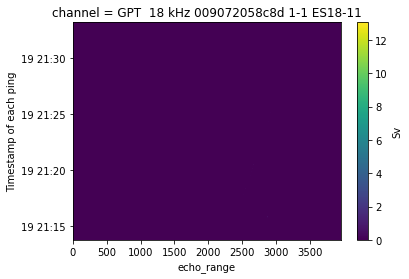

In [34]:
sv.plot()

In [113]:
A = sv.resample(ping_time=ping_time_bin, skipna=True).mean(skipna=True)

In [129]:
np.nanmean(A.data)

67.57070202558651

In [130]:
np.mean(A.data)

nan

In [132]:
A.groupby_bins("echo_range", bins=range_interval, right=False, include_lowest=True)

DataArrayGroupBy, grouped over 'echo_range_bins'
1 groups with labels [0.0,, 20.0).

In [106]:
(
    sv.resample(ping_time=ping_time_bin, skipna=True)
    .mean(skipna=True)
    .groupby_bins("echo_range", bins=range_interval, right=False, include_lowest=True)
    .mean(skipna=True)
)

<xarray.DataArray 'Sv' (ping_time: 1, echo_range_bins: 1)>
array([[nan]])
Coordinates:
  * echo_range_bins  (echo_range_bins) object [0.0, 20.0)
  * ping_time        (ping_time) datetime64[ns] 2021-10-04T23:59:20
    channel          <U25 'WBT 150013-15 ES120-7C_ES'

In [102]:
sv_groupby_bins

<xarray.DataArray 'Sv' (ping_time: 1, echo_range_bins: 1)>
array([[nan]])
Coordinates:
  * echo_range_bins  (echo_range_bins) object [0.0, 20.0)
  * ping_time        (ping_time) datetime64[ns] 2021-10-04T23:59:20
    channel          <U25 'WBT 150013-15 ES120-7C_ES'

In [91]:
sv_groupby_bins.echo_range_bins

<xarray.DataArray 'echo_range_bins' (echo_range_bins: 20)>
array([Interval(0.0, 24.95, closed='left'),
       Interval(24.95, 49.9, closed='left'),
       Interval(49.9, 74.85, closed='left'),
       Interval(74.85, 99.8, closed='left'),
       Interval(99.8, 124.75, closed='left'),
       Interval(124.75, 149.7, closed='left'),
       Interval(149.7, 174.65, closed='left'),
       Interval(174.65, 199.6, closed='left'),
       Interval(199.6, 224.55, closed='left'),
       Interval(224.55, 249.5, closed='left'),
       Interval(249.5, 274.45, closed='left'),
       Interval(274.45, 299.4, closed='left'),
       Interval(299.4, 324.35, closed='left'),
       Interval(324.35, 349.3, closed='left'),
       Interval(349.3, 374.25, closed='left'),
       Interval(374.25, 399.2, closed='left'),
       Interval(399.2, 424.15, closed='left'),
       Interval(424.15, 449.1, closed='left'),
       Interval(449.1, 474.05, closed='left'),
       Interval(474.05, 499.499, closed='left')], dtype=object)
Coordinates:
  * echo_range_bins  (echo_range_bins) object [0.0, 24.95) ... [474.05, 499.499)
    channel          <U25 'WBT 150013-15 ES120-7C_ES'

In [48]:
# set 1D coordinate using the 1st ping echo_range since identical for all pings
sv.coords["echo_range"] = (
    ["range_sample"],
    ds["echo_range"].dropna(dim="range_sample", how="all").dropna(dim="ping_time")
    .isel(ping_time=0).data,
)

ValueError: conflicting sizes for dimension 'range_sample': length 500 on 'echo_range' and length 750 on {'ping_time': 'ping_time', 'range_sample': 'range_sample'}

In [40]:
sv.coords["echo_range"] = (
    ["range_sample"],
    ds["echo_range"].dropna(dim="range_sample", how="all").dropna(dim="ping_time")
    .isel(ping_time=0).data,
)

ValueError: conflicting sizes for dimension 'range_sample': length 500 on 'echo_range' and length 373 on {'ping_time': 'ping_time', 'range_sample': 'range_sample'}

In [34]:
sv.coords["echo_range"] = (
    ["range_sample"],
    ds["echo_range"].dropna(dim="ping_time")
    .isel(ping_time=0).data,
)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [29]:
sv.coords["echo_range"] = (
    ["range_sample"],
    ds["echo_range"].dropna(dim="ping_time")
    .isel(ping_time=0).data,
)

IndexError: index 0 is out of bounds for axis 0 with size 0